### Split the data into test and training sets

In [1]:
import os
import random

path = './data_folder'
emotions = os.listdir(path)

training = []
testing = []

for emotion in emotions:
    clips = os.listdir(f'{path}/{emotion}')
    train = random.sample(clips, 70)
    test = [clip for clip in clips if clip not in train]
    training.append(train)
    testing.append(test)

### Put the filename and its classification into a dataframe

In [2]:
import pandas as pd
import numpy as np

df_train = pd.DataFrame()
df_test = pd.DataFrame()

training_flat = [file for files in training for file in files]
testing_flat = [file for files in testing for file in files]

training_labels = np.repeat(emotions, 70).tolist()
testing_labels = np.repeat(emotions, 30).tolist()

df_train['file'] = training_flat
df_train['label'] = training_labels

df_test['file'] = testing_flat
df_test['label'] = testing_labels

### We already know that the dataset is evenly distributed 25%, 25%, 25%, 25% so we can look at the data itself

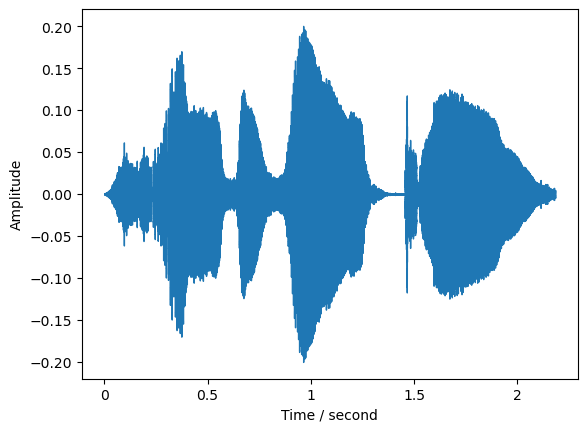

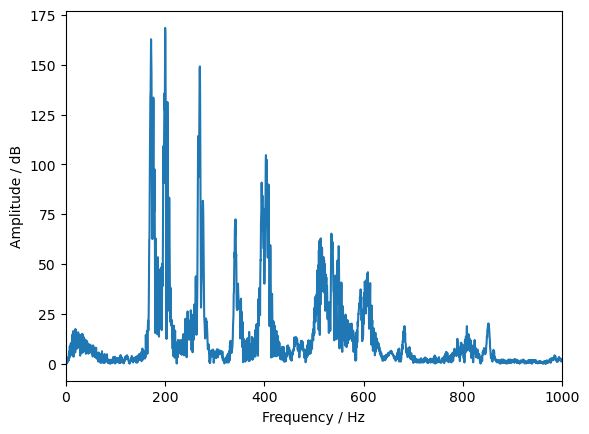

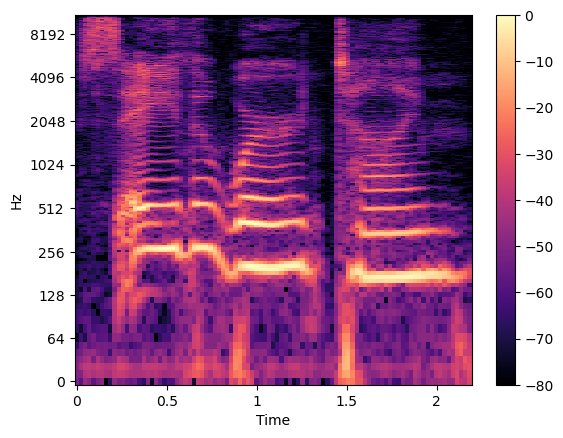

In [3]:
import librosa
import matplotlib.pyplot as plt

signal, rate = librosa.load(f'{path}/{df_test["label"][0]}/{df_test["file"][0]}')

plt.figure(1)
librosa.display.waveshow(y=signal, sr=rate)
plt.xlabel('Time / second')
plt.ylabel('Amplitude')
plt.show()

k = np.arange(len(signal))
T = len(signal)/rate
freq = k/T

DATA_0 = np.fft.fft(signal)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.xlabel("Frequency / Hz")
plt.ylabel("Amplitude / dB")
plt.xlim([0, 1000])
plt.show()

D = librosa.stft(signal)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

### Define some functions for feature extraction

In [4]:
def extractLoudness(signal):
    df_loudness = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(signal))
    rms = librosa.feature.rms(S=S)
    df_loudness['Loudness'] = rms[0]
    return df_loudness

def extractMFCCS(signal, sample_rate):
    df_mfccs = pd.DataFrame()
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12)
    for n_mfcc in range(len(mfccs)):
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
    return df_mfccs

def extractZeroCrossingRate(signal):
    df_zero_crossing_rate = pd.DataFrame()
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    df_zero_crossing_rate['ZCR'] = zcr[0]
    return df_zero_crossing_rate

def extractChroma(signal, sample_rate):
    df_chroma = pd.DataFrame()
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
    for n_chroma in range(len(chromagram)):
        df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]
    return df_chroma

def extractMelSpectrogram(signal, sample_rate):
    df_mel_spectrogram = pd.DataFrame()
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12)
    for n_mel in range(len(mel_spectrogram)):
        df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]
    return df_mel_spectrogram

def matrixToVector(matrixFeatures):
    vector = []
    for label in matrixFeatures.columns:
        if label == 'Loudness' or label == 'ZCR':
            vector.append(np.mean(matrixFeatures[label].dropna().to_numpy()))
        else:
            vector.extend(matrixFeatures[label].dropna().to_numpy())
    return vector

# Extract all the features

In [5]:
features_test = []
for i in range(df_test['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_test["label"][i]}/{df_test["file"][i]}')
    matrix = pd.concat([
        extractLoudness(signal), 
        extractMFCCS(signal, rate), 
        extractZeroCrossingRate(signal),
        extractChroma(signal, rate),
        extractMelSpectrogram(signal, rate)])
    features_test.append(matrixToVector(matrix))

features_train = []
for i in range(df_train['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_train["label"][i]}/{df_train["file"][i]}')
    matrix = pd.concat([
        extractLoudness(signal), 
        extractMFCCS(signal, rate), 
        extractZeroCrossingRate(signal),
        extractChroma(signal, rate),
        extractMelSpectrogram(signal, rate)])
    features_train.append(matrixToVector(matrix))

### Generate the x and y values for the test and training data

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

ss = StandardScaler()
le = LabelEncoder()

x_train = ss.fit_transform(features_train)
x_test = ss.fit_transform(features_test)

le.fit(df_train['label'])
y_train = le.transform(df_train['label'])
y_test = le.transform(df_test['label'])

### Build the classifiers

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

logistic = LogisticRegression(multi_class='multinomial')
bayes = GaussianNB()
neighbors = KNeighborsClassifier()
tree = DecisionTreeClassifier()
svc = LinearSVC(multi_class='crammer_singer')

### Fit and train the classifiers

In [8]:
logistic.fit(x_train, y_train)
bayes.fit(x_train, y_train)
neighbors.fit(x_train, y_train)
tree.fit(x_train, y_train)
svc.fit(x_train, y_train)

LinearSVC(multi_class='crammer_singer')

### Predict and metrics

In [9]:
predictions = []
scores = []

predictions.append(logistic.predict(x_test))
scores.append(logistic.score(x_test, y_test))

predictions.append(bayes.predict(x_test))
scores.append(bayes.score(x_test, y_test))

predictions.append(neighbors.predict(x_test))
scores.append(neighbors.score(x_test, y_test))

predictions.append(tree.predict(x_test))
scores.append(tree.score(x_test, y_test))

predictions.append(svc.predict(x_test))
scores.append(svc.score(x_test, y_test))

/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the

### Define functions to display results

In [16]:
from sklearn import metrics

def plotResults():
    models = ['Logistic Regression', 'Bayes', 'K Neighbors', 'Decision Tree', 'SVC']

    for model, prediction, score in zip(models, predictions, scores):
        # print(metrics.classification_report(y_test, prediction, target_names=le.classes_))
        disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test.ravel(), prediction))
        disp.plot(
            include_values=True,
            cmap='gray',
            colorbar=False
        )
        disp.ax_.set_title(f"{model} Accuracy Score: {score*100}%")

### Display results

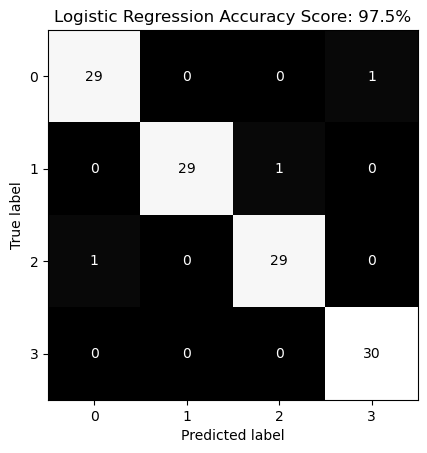

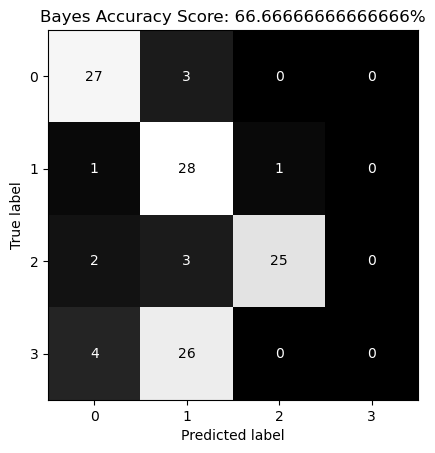

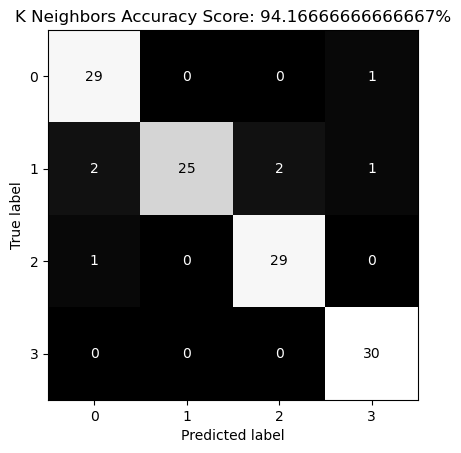

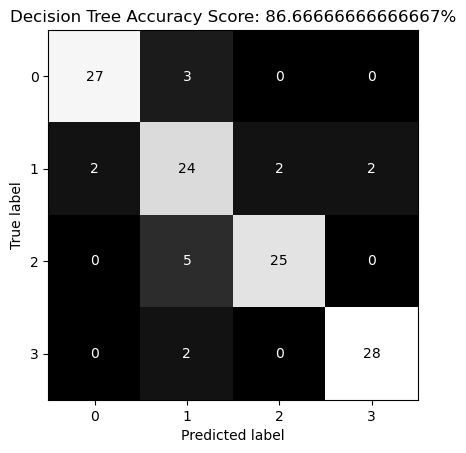

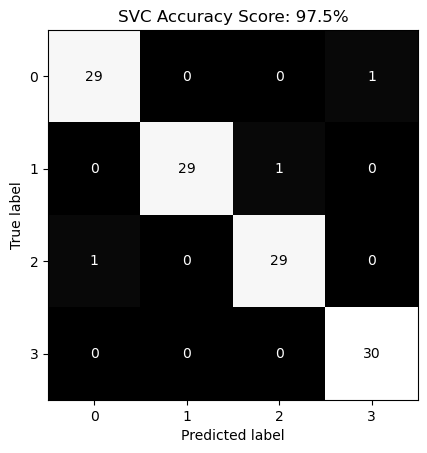

In [17]:
plotResults()

# Drop loudness and zero crossing rate

/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically pre

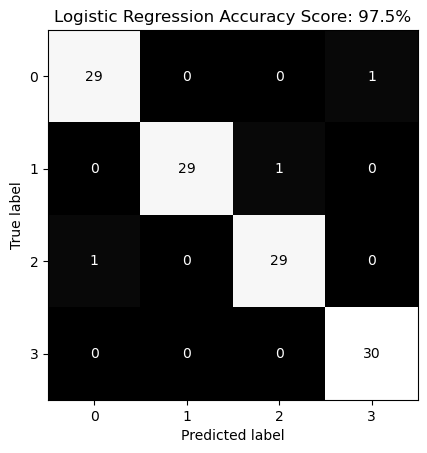

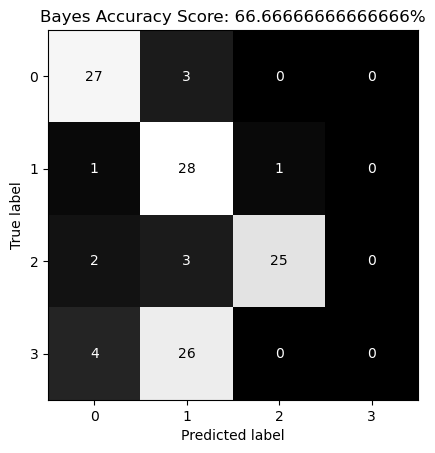

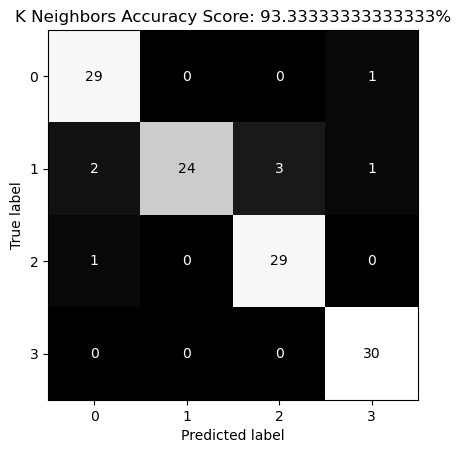

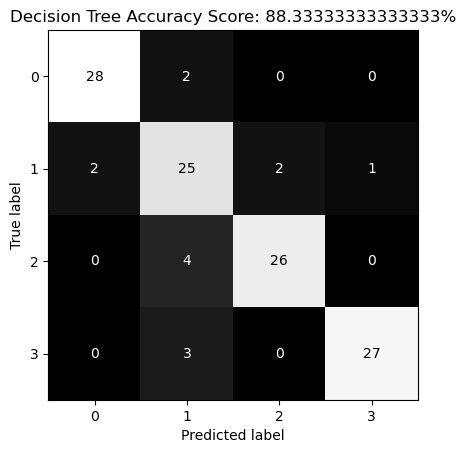

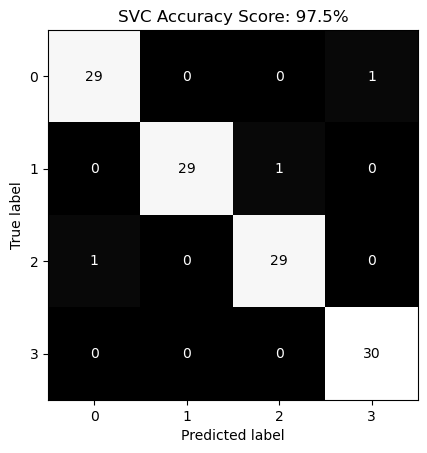

In [24]:
features_test = []
for i in range(df_test['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_test["label"][i]}/{df_test["file"][i]}')
    matrix = pd.concat([
        extractMFCCS(signal, rate), 
        extractChroma(signal, rate),
        extractMelSpectrogram(signal, rate)])
    features_test.append(matrixToVector(matrix))

features_train = []
for i in range(df_train['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_train["label"][i]}/{df_train["file"][i]}')
    matrix = pd.concat([
        extractMFCCS(signal, rate), 
        extractChroma(signal, rate),
        extractMelSpectrogram(signal, rate)])
    features_train.append(matrixToVector(matrix))

x_train = ss.fit_transform(features_train)
x_test = ss.fit_transform(features_test)

logistic = LogisticRegression(multi_class='multinomial')
bayes = GaussianNB()
neighbors = KNeighborsClassifier()
tree = DecisionTreeClassifier()
svc = LinearSVC(multi_class='crammer_singer')

logistic.fit(x_train, y_train)
bayes.fit(x_train, y_train)
neighbors.fit(x_train, y_train)
tree.fit(x_train, y_train)
svc.fit(x_train, y_train)

predictions = []
scores = []

predictions.append(logistic.predict(x_test))
scores.append(logistic.score(x_test, y_test))

predictions.append(bayes.predict(x_test))
scores.append(bayes.score(x_test, y_test))

predictions.append(neighbors.predict(x_test))
scores.append(neighbors.score(x_test, y_test))

predictions.append(tree.predict(x_test))
scores.append(tree.score(x_test, y_test))

predictions.append(svc.predict(x_test))
scores.append(svc.score(x_test, y_test))

plotResults()

# Drop Chroma and MFCC

/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically pre

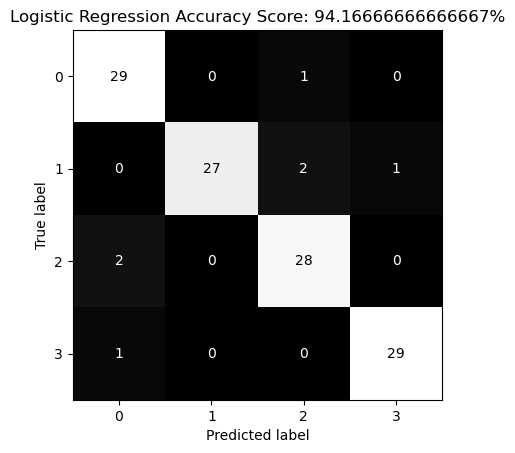

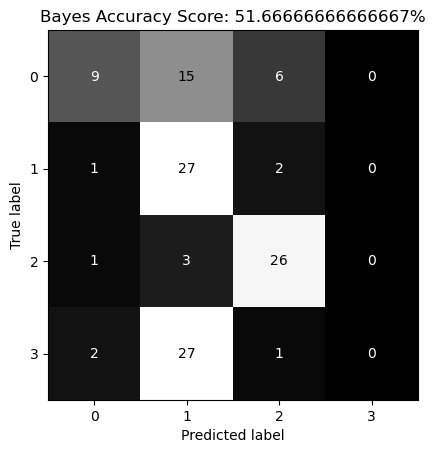

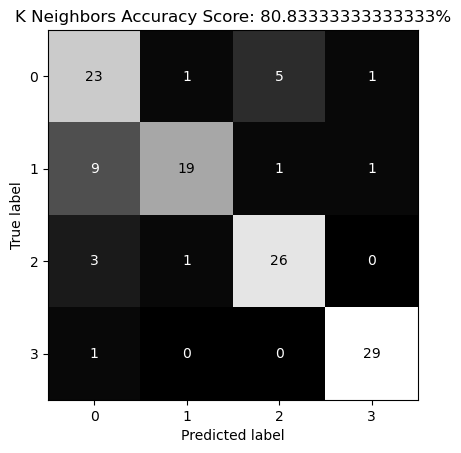

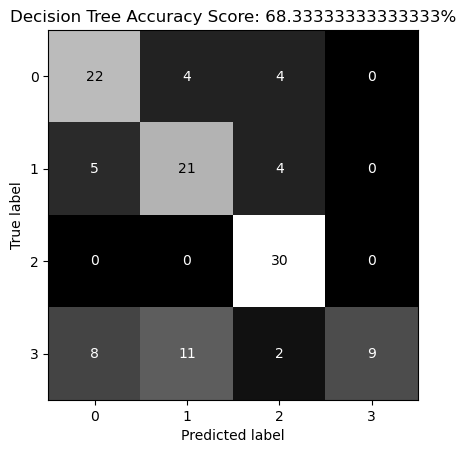

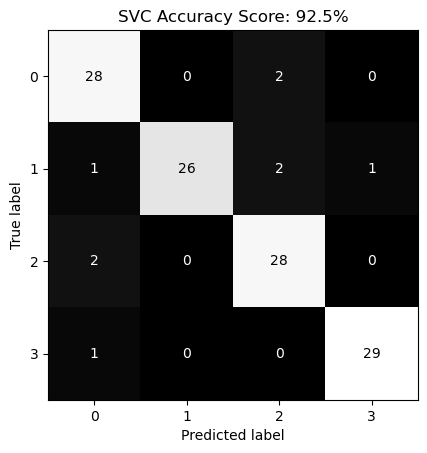

In [25]:
features_test = []
for i in range(df_test['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_test["label"][i]}/{df_test["file"][i]}')
    matrix = pd.concat([
        extractLoudness(signal),
        extractZeroCrossingRate(signal),
        extractMelSpectrogram(signal, rate)])
    features_test.append(matrixToVector(matrix))

features_train = []
for i in range(df_train['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_train["label"][i]}/{df_train["file"][i]}')
    matrix = pd.concat([
        extractLoudness(signal),
        extractZeroCrossingRate(signal),
        extractMelSpectrogram(signal, rate)])
    features_train.append(matrixToVector(matrix))

x_train = ss.fit_transform(features_train)
x_test = ss.fit_transform(features_test)

logistic = LogisticRegression(multi_class='multinomial')
bayes = GaussianNB()
neighbors = KNeighborsClassifier()
tree = DecisionTreeClassifier()
svc = LinearSVC(multi_class='crammer_singer')

logistic.fit(x_train, y_train)
bayes.fit(x_train, y_train)
neighbors.fit(x_train, y_train)
tree.fit(x_train, y_train)
svc.fit(x_train, y_train)

predictions = []
scores = []

predictions.append(logistic.predict(x_test))
scores.append(logistic.score(x_test, y_test))

predictions.append(bayes.predict(x_test))
scores.append(bayes.score(x_test, y_test))

predictions.append(neighbors.predict(x_test))
scores.append(neighbors.score(x_test, y_test))

predictions.append(tree.predict(x_test))
scores.append(tree.score(x_test, y_test))

predictions.append(svc.predict(x_test))
scores.append(svc.score(x_test, y_test))

plotResults()

# Drop MFCC and Mel Spectrogram

/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically pre

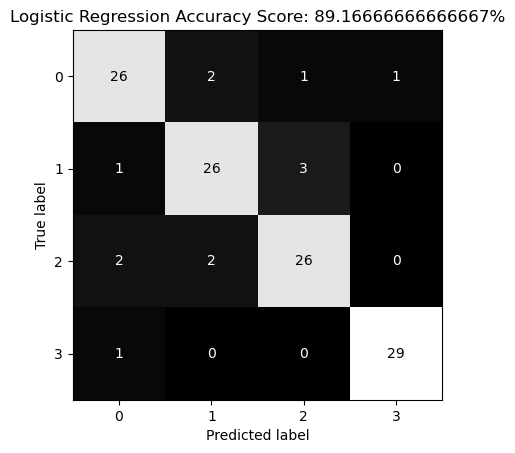

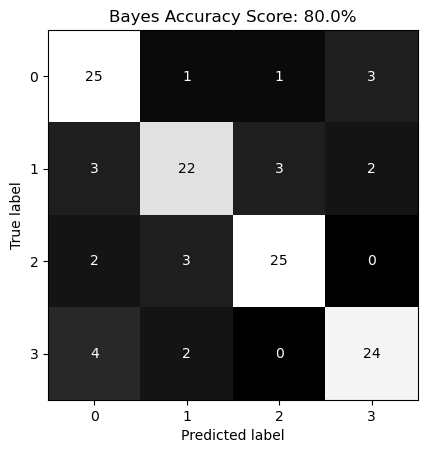

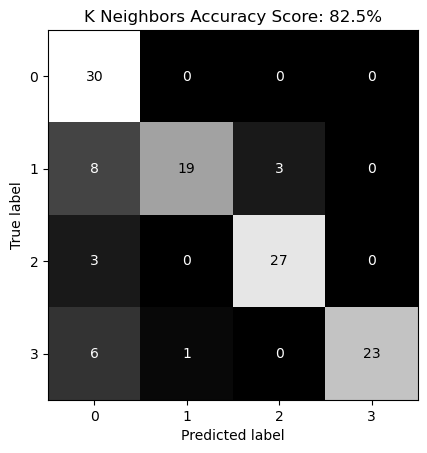

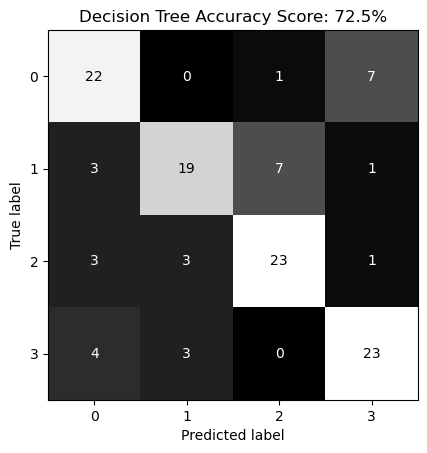

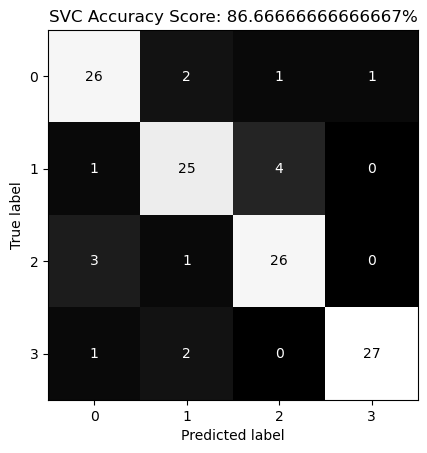

In [26]:
features_test = []
for i in range(df_test['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_test["label"][i]}/{df_test["file"][i]}')
    matrix = pd.concat([
        extractLoudness(signal),
        extractZeroCrossingRate(signal),
        extractChroma(signal, rate)])
    features_test.append(matrixToVector(matrix))

features_train = []
for i in range(df_train['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_train["label"][i]}/{df_train["file"][i]}')
    matrix = pd.concat([
        extractLoudness(signal),
        extractZeroCrossingRate(signal),
        extractChroma(signal, rate)])
    features_train.append(matrixToVector(matrix))

x_train = ss.fit_transform(features_train)
x_test = ss.fit_transform(features_test)

logistic = LogisticRegression(multi_class='multinomial')
bayes = GaussianNB()
neighbors = KNeighborsClassifier()
tree = DecisionTreeClassifier()
svc = LinearSVC(multi_class='crammer_singer')

logistic.fit(x_train, y_train)
bayes.fit(x_train, y_train)
neighbors.fit(x_train, y_train)
tree.fit(x_train, y_train)
svc.fit(x_train, y_train)

predictions = []
scores = []

predictions.append(logistic.predict(x_test))
scores.append(logistic.score(x_test, y_test))

predictions.append(bayes.predict(x_test))
scores.append(bayes.score(x_test, y_test))

predictions.append(neighbors.predict(x_test))
scores.append(neighbors.score(x_test, y_test))

predictions.append(tree.predict(x_test))
scores.append(tree.score(x_test, y_test))

predictions.append(svc.predict(x_test))
scores.append(svc.score(x_test, y_test))

plotResults()

# Drop Mel Spectrogram and Chroma

/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/markpolkhovskiy/anaconda3/envs/hw2/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically pre

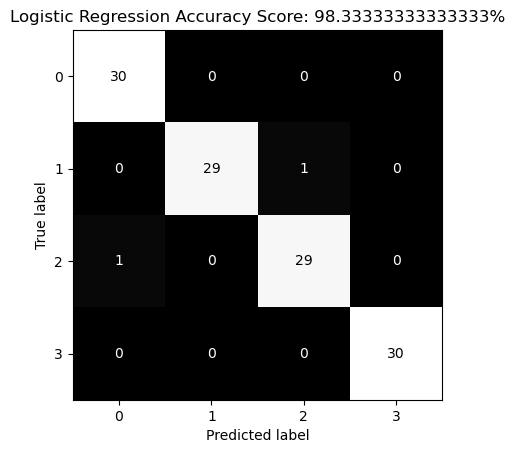

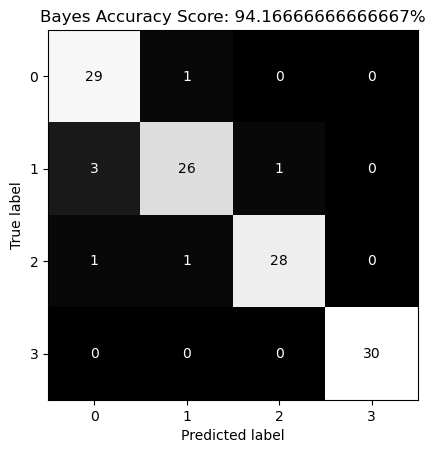

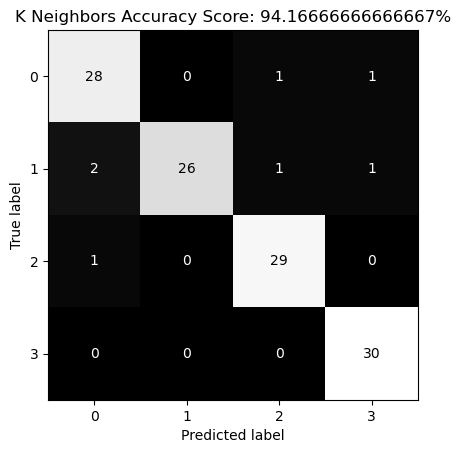

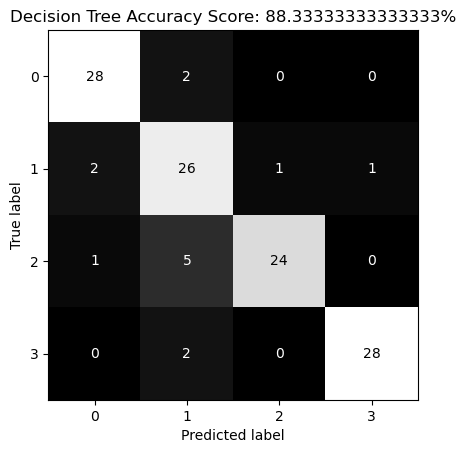

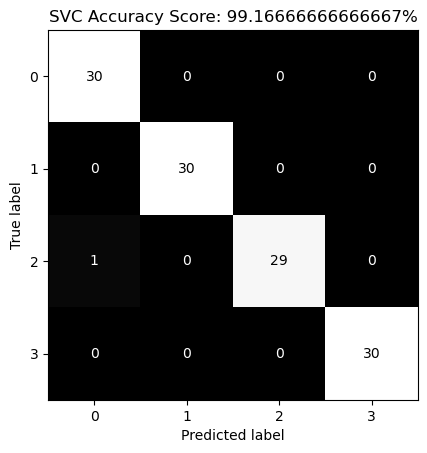

In [27]:
features_test = []
for i in range(df_test['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_test["label"][i]}/{df_test["file"][i]}')
    matrix = pd.concat([
        extractLoudness(signal),
        extractZeroCrossingRate(signal),
        extractMFCCS(signal, rate)])
    features_test.append(matrixToVector(matrix))

features_train = []
for i in range(df_train['file'].count()):
    signal, rate = librosa.load(f'{path}/{df_train["label"][i]}/{df_train["file"][i]}')
    matrix = pd.concat([
        extractLoudness(signal),
        extractZeroCrossingRate(signal),
        extractMFCCS(signal, rate)])
    features_train.append(matrixToVector(matrix))

x_train = ss.fit_transform(features_train)
x_test = ss.fit_transform(features_test)

logistic = LogisticRegression(multi_class='multinomial')
bayes = GaussianNB()
neighbors = KNeighborsClassifier()
tree = DecisionTreeClassifier()
svc = LinearSVC(multi_class='crammer_singer')

logistic.fit(x_train, y_train)
bayes.fit(x_train, y_train)
neighbors.fit(x_train, y_train)
tree.fit(x_train, y_train)
svc.fit(x_train, y_train)

predictions = []
scores = []

predictions.append(logistic.predict(x_test))
scores.append(logistic.score(x_test, y_test))

predictions.append(bayes.predict(x_test))
scores.append(bayes.score(x_test, y_test))

predictions.append(neighbors.predict(x_test))
scores.append(neighbors.score(x_test, y_test))

predictions.append(tree.predict(x_test))
scores.append(tree.score(x_test, y_test))

predictions.append(svc.predict(x_test))
scores.append(svc.score(x_test, y_test))

plotResults()